In [1]:
from torchvision import datasets
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torch import nn
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.sparse as sp
import torch
from IPython.display import HTML

In [20]:
device = 'cpu'

In [21]:
path = './archive/DATASET JERUK'

In [22]:
# !unzip -qq $path -d corel

In [23]:
files = os.listdir('./archive/DATASET JERUK')
len(files)

296

In [24]:
#  [i for i in files if i.split('.')[1]=='db']

In [25]:
# os.remove('./corel/Corel100/Thumbs.db')
# os.remove(os.path.join(ROOT, files[5809]))

In [26]:
ROOT = './archive/DATASET JERUK'
n_dims = 25088

In [27]:
class CBIRDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.images = os.listdir(root)
        self.transforms = transforms

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.root, self.images[idx]))
        img = self.transforms(img)
        return idx, img

    def __len__(self):
        return len(self.images)

In [28]:
transforms = T.Compose([
    T.Resize(size=(224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

dsetCBIR = CBIRDataset(ROOT, transforms)

In [29]:
dataloader = DataLoader(dsetCBIR, batch_size=64)

In [30]:
model = models.vgg16(pretrained=True)

In [31]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [32]:
model.classifier = Identity()

In [33]:
preds = sp.lil_matrix((len(dsetCBIR), n_dims))
preds.shape

(296, 25088)

In [34]:
model.to(device)
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [18]:
torch.cuda.empty_cache()


In [35]:
from tqdm.notebook import trange, tqdm
for i, img in tqdm(dataloader):
    pred = model(img.to(device))
    preds[i.min() : i.max() + 1, :] = pred.cpu().detach()

  0%|          | 0/5 [00:00<?, ?it/s]

In [36]:
def cosine_similarity(ratings):
    sim = ratings.dot(ratings.T)
    if not isinstance(sim, np.ndarray):
        sim = sim.toarray()
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [42]:
preds = preds.tocsr()
sim = cosine_similarity(preds)
print(preds)

  (0, 0)	1.44443678855896
  (0, 11)	2.744438648223877
  (0, 12)	1.4556108713150024
  (0, 13)	0.0890260562300682
  (0, 20)	0.21938487887382507
  (0, 27)	0.32622456550598145
  (0, 38)	0.20329774916172028
  (0, 49)	1.484277606010437
  (0, 50)	1.5406559705734253
  (0, 51)	1.6050888299942017
  (0, 52)	1.5817341804504395
  (0, 53)	1.6411222219467163
  (0, 54)	4.696493625640869
  (0, 55)	5.448517322540283
  (0, 56)	3.2393455505371094
  (0, 57)	3.1688597202301025
  (0, 62)	2.417750597000122
  (0, 63)	2.923893690109253
  (0, 64)	4.370438098907471
  (0, 65)	1.8050148487091064
  (0, 69)	2.180117607116699
  (0, 70)	1.2026283740997314
  (0, 71)	2.528034210205078
  (0, 72)	2.3744394779205322
  (0, 73)	2.0382158756256104
  :	:
  (295, 24981)	3.5146687030792236
  (295, 24982)	3.88065505027771
  (295, 24985)	0.4541172981262207
  (295, 24987)	2.302852153778076
  (295, 24988)	2.9589672088623047
  (295, 24989)	2.118504524230957
  (295, 24994)	3.032029151916504
  (295, 24995)	3.9284634590148926
  (295, 250

In [38]:
def get_thumbnails(sim, idx, N=10):
    row = sim[idx, :]
    thumbs = []
    files = os.listdir(ROOT)

    for x in np.argsort(-row)[:N]:

        thumbs.append(files[x])
    
    return thumbs

In [39]:
def display_thumbs(thumbs, N=9):

    display(HTML('<font size=5>'+'Query Image'+'</font>'))

    fig, ax = plt.subplots(figsize=(3,3))
    ax.axis('off')
    ax.imshow(Image.open(os.path.join(ROOT, thumbs[0])))
    plt.show()

    display(HTML('<font size=5>'+'Retrieved Images'+'</font>'))


    fig = plt.figure(figsize=(10, 10))

    for i, img in enumerate(thumbs[1:N+1]):
        image = Image.open(os.path.join(ROOT, img))
        fig.add_subplot(3, 3, i+1)
        plt.axis('off')
        plt.imshow(image)

    plt.show()

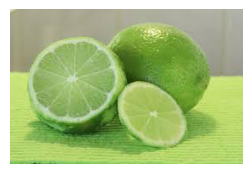

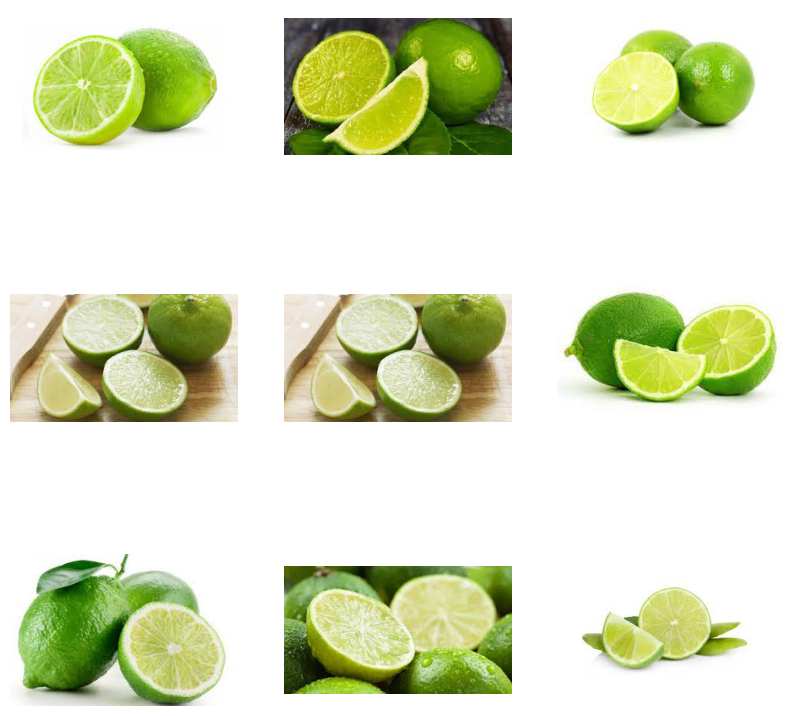

In [44]:
display_thumbs(get_thumbnails(sim, 207, N=10), N=9)